In [2]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from scipy.misc import imsave
from scipy.misc import imresize
import cv2
from scipy.misc import imread
from scipy.ndimage import convolve
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from layers.data_utils import get_CIFAR10_grayscale

# Load the (preprocessed) CIFAR10 data.
x_train, y_train, x_val, y_val, _, _ = get_CIFAR10_grayscale(num_training=10000, num_validation=1000, num_test=0,
                     subtract_mean=False)
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_val))
print(np.shape(y_val))

(10000, 32, 32)
(10000,)
(1000, 32, 32)
(1000,)


INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000
INFO:tensorflow:Restoring parameters from /media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000


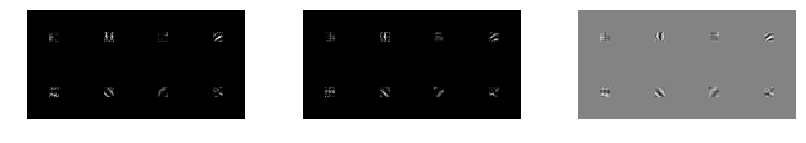

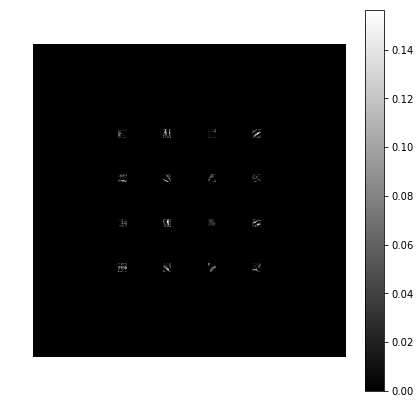

In [4]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

def print_tensors_in_ckpt(ckpt_path):
    print_tensors_in_checkpoint_file(ckpt_path, 
                                          tensor_name='', all_tensors=False)
    
def load_variable_from_checkpoint(tensor_name, shape, ckpt_path, dtype=tf.float64):
    tf.reset_default_graph()

    # Load checkpoint from disk to compare phase shifts found by tensorflow
    tensor_graph = tf.get_variable(tensor_name, shape=shape, dtype=dtype)
    with tf.Session() as sess:
        saver = tf.train.Saver([tensor_graph])
        saver.restore(sess, ckpt_path)
        
        tensor_value = sess.run(tensor_graph)

    return tensor_value

nn_ckpt_path = '/media/data/checkpoints/onn/hybrid_cifar10/optneg_9x8_1e-1/model.ckpt-15000' # fabrication
# print_tensors_in_ckpt(nn_ckpt_path)

b_conv1 = load_variable_from_checkpoint('conv1/b_conv1', [8], nn_ckpt_path, dtype=tf.float32)
W_fc1 = load_variable_from_checkpoint('W_fc1', [8192, 10], nn_ckpt_path, dtype=tf.float32)
b_fc1 = load_variable_from_checkpoint('fc/b_fc1', [10], nn_ckpt_path, dtype=tf.float32)

convdim = 9
depth = 8
pad = (48-convdim)//2
rows = 2
cols = 4

varname = 'conv1/W_conv1_pos'
var1 = load_variable_from_checkpoint(varname, [convdim,convdim,1,depth], nn_ckpt_path, dtype=tf.float32)
W_conv1_pos = np.abs(var1.squeeze())

varname = 'conv1/W_conv1_neg'
var2 = load_variable_from_checkpoint(varname, [convdim,convdim,1,depth], nn_ckpt_path, dtype=tf.float32)
W_conv1_neg = np.abs(var2.squeeze())

kernels_pos_pad = [np.pad(W_conv1_pos[:,:,i], (pad,pad), 'constant') for i in range(depth)]
psf_pos = np.concatenate(
    [np.concatenate((kernels_pos_pad[i*cols:(i+1)*cols]), axis=1) for i in range(rows)], axis=0)
kernels_neg_pad = [np.pad(W_conv1_neg[:,:,i], (pad,pad), 'constant') for i in range(depth)]
psf_neg = np.concatenate(
    [np.concatenate((kernels_neg_pad[i*cols:(i+1)*cols]), axis=1) for i in range(rows)], axis=0)


psf_sub = psf_pos - psf_neg
fig, ax = plt.subplots(nrows=1, ncols=3)
plt.subplot(131)
plt.imshow(psf_pos, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(psf_neg, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(psf_sub, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(14, 2)
plt.show()

extra_pad = 70# 100#  int(.5*np.shape(psf)[0])
psf = np.concatenate((psf_pos, psf_neg), axis=0)
psf = np.pad(psf, (extra_pad, extra_pad), 'constant')
dim = np.shape(psf)[0]

plt.imshow(psf, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.gcf().set_size_inches(7,7) 
plt.show()
#imsave('target_psf.png', Iconv, cmap='gray')

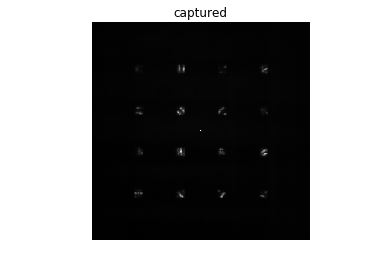

In [43]:
# load captured PSF
# compare to captured images
psf_file = 'prototype/square_halfsz5.png'
psf_cap = (imread(psf_file))
psf_cap = psf_cap.astype(float)
psf_cap = cv2.resize(psf_cap, (252,252))
plt.imshow(psf_cap, cmap='gray')
plt.axis('equal')
plt.axis('off')
plt.title('captured')
plt.show()

psf_cap -= 100
psf_cap = np.maximum(psf_cap, 0)

# np.save('prototype/psf_cap.npy', psf_cap)

class:  9


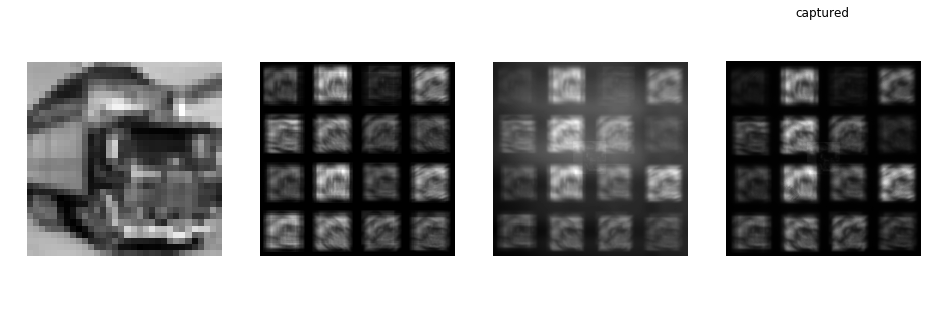

sim:  1.68501684854 2.08307839125e-19
41073.0 248.0


In [79]:
# choose image
idx =14; np.random.randint(0, 1000)
I = x_train[idx,:,:]

###### convolve
pad_amt = (dim - 32)//2
Ipad = np.pad(I, ((pad_amt, pad_amt)), 'constant', constant_values = (0,0)) 
otf = np.fft.fft2(np.fft.ifftshift(psf))
Ift = np.fft.fft2(Ipad)
Iconv = np.abs(np.fft.ifft2(Ift*otf))

fig, ax = plt.subplots(nrows=1, ncols=4)
plt.subplot(141)
plt.imshow(I, cmap='gray')
plt.axis('off')

plt.subplot(142)
plt.imshow(Iconv[extra_pad:-extra_pad,extra_pad:-extra_pad], cmap='gray')
plt.axis('off')

###### convolve with captured psf
dim_cap = 252
pad_amt_cap = (dim_cap - 32)//2
Ipad_cap = np.pad(I, ((pad_amt_cap, pad_amt_cap)), 'constant', constant_values = (0,0)) 
otf_cap = np.fft.fft2(np.fft.ifftshift(psf_cap))
Ift = np.fft.fft2(Ipad_cap)
Iconv_cap = np.abs(np.fft.ifft2(Ift*otf_cap))

plt.subplot(143)
extra_pad_ccap = 30;
plt.imshow(Iconv_cap[extra_pad_ccap:-extra_pad_ccap,extra_pad_ccap:-extra_pad_ccap], cmap='gray')
plt.axis('off')

# compare to captured images
imdir = '/media/data/onn/prototype/training_gamma5/'
print('class: ', y_train[idx])
imfile = 'capture_%05d.png' % (idx+1)

Icap = (imread(imdir+imfile))
Icap = Icap.astype(float)

plt.subplot(144)
extra_pad_cap = 120;
plt.imshow(Icap[extra_pad_cap:-extra_pad_cap,extra_pad_cap:-extra_pad_cap], cmap='gray')
plt.axis('equal')
plt.axis('off')
plt.title('captured')

plt.gcf().set_size_inches(16, 5)
plt.show()

print('sim: ', np.max(Iconv), np.min(Iconv))
print(np.max(Icap), np.min(Icap))

imsave('prototype/output_sim.png', Iconv[extra_pad:-extra_pad,extra_pad:-extra_pad])
imsave('prototype/output_cap.png', Icap[extra_pad_cap:-extra_pad_cap,extra_pad_cap:-extra_pad_cap])
imsave('prototype/input.png', Ipad[extra_pad:-extra_pad,extra_pad:-extra_pad])

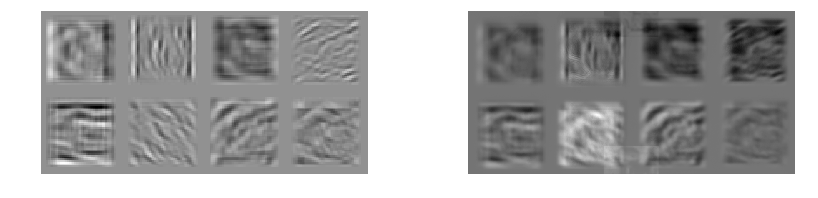

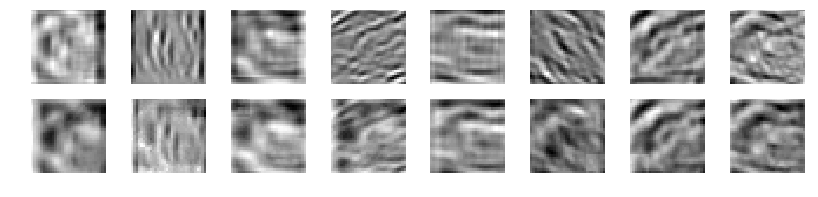

1.0 -0.165493156509 -1.63077298704
cap:  1.0 -0.104566335727 -0.803428042001


In [76]:
######### subsection simulated images
Iconv_unpad = Iconv[extra_pad:-extra_pad, extra_pad:-extra_pad]
dim_unpad = np.shape(Iconv_unpad)[0]
Iconv_sub = Iconv_unpad[:int(dim_unpad/2), :] - Iconv_unpad[int(dim_unpad/2):, :]

tile_size = 47
h_pad1 = int(np.ceil((tile_size-32)/2))
h_pad2 = int(np.floor((tile_size-32)/2))
h_conv1_split1d = np.array_split(Iconv_unpad, 2*rows, axis=0)
h_conv1_split2d = np.concatenate([np.array_split(h_conv1_split1d[i], cols, axis=1) for i in range(2*rows)], axis=0)
h_conv1_both = np.transpose(h_conv1_split2d[:, h_pad1:-h_pad2, h_pad1:-h_pad2], (1, 2, 0)) 
h_conv1_subtracted = h_conv1_both[:,:,:depth] - h_conv1_both[:,:,depth:]
# print(np.max(h_conv1_subtracted, axis=(0,1)))
h_conv1_subtracted /= np.max(h_conv1_subtracted)

######## subsection captured images
tile_size = 196
subimg_size = 128
extra_pad_t = int(np.floor((1024 - 4*tile_size)/2))
extra_pad_b = int(np.ceil((1024 - 4*tile_size)/2))
extra_pad_l = int(np.floor((1024 - 4*tile_size)/2))
extra_pad_r = int(np.ceil((1024 - 4*tile_size)/2))
h_pad1 = int(np.floor((tile_size - subimg_size)/2))
h_pad2 = int(np.ceil((tile_size - subimg_size)/2))
depth = 8

Icap_unpad = Icap[extra_pad_t:-extra_pad_b,extra_pad_l:-extra_pad_r]
dim_unpad = dim_unpad = np.shape(Icap_unpad)[0]
Icap_sub = Icap_unpad[:int(dim_unpad/2), :] - Icap_unpad[int(dim_unpad/2):, :]

######## plot
fig, ax = plt.subplots(nrows=1, ncols=2)
plt.subplot(1,2,1)
plt.imshow(Iconv_sub, cmap='gray')
plt.axis('equal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Icap_sub, cmap='gray')
plt.axis('equal')
plt.axis('off')
plt.gcf().set_size_inches(14, 3)
plt.show()

######## separate into sub images
I_split1d = np.array_split(Icap_unpad, 4, axis=0)
I_split2d = np.concatenate([np.array_split(I_split1d[i], 4, axis=1) for i in range(4)], axis=0)
h_conv1_both = np.transpose(I_split2d[:, h_pad1:-h_pad2, h_pad1:-h_pad2], (1, 2, 0)) 
h_conv1_subtracted_cap = h_conv1_both[:,:,:depth] - h_conv1_both[:,:,depth:]
h_conv1_cap = np.zeros((32,32,8))
for c in range(8):
    h_conv1_cap[:,:,c] = cv2.resize(h_conv1_subtracted_cap[:,:,c], (32, 32), interpolation=cv2.INTER_NEAREST)

h_conv1_cap /= np.max(h_conv1_cap)

fig, ax = plt.subplots(nrows=2, ncols=8)
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(h_conv1_subtracted[:,:,i], cmap='gray')
    plt.axis('equal')
    plt.axis('off')
    # imsave('prototype/sub_sim_%d.png' % i, h_conv1_subtracted[:,:,i])
    
    plt.subplot(2,8,i+9)
    plt.imshow(h_conv1_cap[:,:,i], cmap='gray')
    plt.axis('equal')
    plt.axis('off')
    # imsave('prototype/sub_capt_%d.png' % i, h_conv1_cap[:,:,i])

plt.gcf().set_size_inches(14, 3)
plt.show()

print(np.max(h_conv1_subtracted), np.mean(h_conv1_subtracted), np.min(h_conv1_subtracted))
print('cap: ',  np.max(h_conv1_cap), np.mean(h_conv1_cap), np.min(h_conv1_cap))

In [46]:
def predict_class(I): 
    # split into subimages
    tile_size = 196
    subimg_size = 130
    extra_pad_t = int(np.floor((1024 - 4*tile_size)/2))
    extra_pad_b = int(np.ceil((1024 - 4*tile_size)/2))
    extra_pad_l = int(np.floor((1024 - 4*tile_size)/2))
    extra_pad_r = int(np.ceil((1024 - 4*tile_size)/2))
    h_pad1 = int(np.floor((tile_size - subimg_size)/2))
    h_pad2 = int(np.ceil((tile_size - subimg_size)/2))
    depth = 8

    Icap_unpad = Icap[extra_pad_t:-extra_pad_b,extra_pad_l:-extra_pad_r]
    dim_unpad = dim_unpad = np.shape(Icap_unpad)[0]
    Icap_sub = Icap_unpad[:int(dim_unpad/2), :] - Icap_unpad[int(dim_unpad/2):, :]

    I_split1d = np.array_split(Icap_unpad, 4, axis=0)
    I_split2d = np.concatenate([np.array_split(I_split1d[i], 4, axis=1) for i in range(4)], axis=0)
    h_conv1_both = np.transpose(I_split2d[:, h_pad1:-h_pad2, h_pad1:-h_pad2], (1, 2, 0)) 
    h_conv1_subtracted_cap = h_conv1_both[:,:,:depth] - h_conv1_both[:,:,depth:]
    h_conv1 = np.zeros((32,32,8))
    for c in range(8):
        h_conv1[:,:,c] = cv2.resize(h_conv1_subtracted_cap[:,:,c], (32, 32), interpolation=cv2.INTER_NEAREST)

    h_conv1 /= np.max(h_conv1)
    
    doPlot = False
    if doPlot:
        fig, ax = plt.subplots(nrows=2, ncols=4)
        for c in range(8):
            plt.subplot(2,4,c+1)
            plt.imshow(h_conv1[:,:,c], cmap='gray')
            plt.axis('equal')
            plt.axis('off')
        plt.gcf().set_size_inches(13, 6)
        plt.show()

    h_conv1 = h_conv1 + b_conv1
    np.maximum(0, h_conv1, h_conv1)
    # print(np.shape(h_conv1))

    # feed to FC layer
    h_conv1_flat = np.reshape(h_conv1, 32*32*depth)
    y_out = np.matmul(h_conv1_flat, W_fc1) + b_fc1

    return y_out



In [48]:
n_val = 50
y_pred = np.zeros(n_val)
verbose = False
for i in range(n_val):
    # check captured images
    imdir = '/media/data/onn/prototype/training_gamma5/'
    imfile = 'capture_%05d.png' % (i+1)
    I = imread(imdir+imfile)
    
    # make prediction
    y_out = predict_class(I)
    y_pred[i] = np.argmax(y_out)

    if verbose:
        print('predicted: \t', y_pred[i])
        print('actual: \t', y_val[i])
        
accuracy = np.mean(np.equal(y_pred, y_train[:n_val]))
print('accuracy: \t', accuracy)

accuracy: 	 0.1


In [51]:
from glob import glob
file_list = glob("/media/data/onn/prototype/training_gamma5/capture_*.png")
print(len(file_list))

file_list_sort = sorted(file_list)
print(file_list_sort[1000])

50000
/media/data/onn/prototype/training_gamma5/capture_01001.png


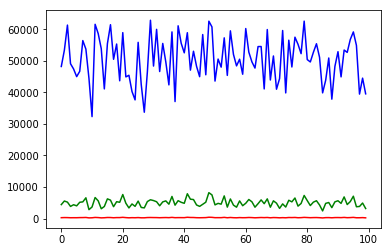

In [19]:
# check dataset drift
numTrain = 100
stats_max = np.zeros((numTrain,1))
stats_mean = np.zeros((numTrain,1))
stats_min = np.zeros((numTrain,1))
for i in range(numTrain):
    imdir = '/media/data/onn/prototype/training_gamma5/'
    imfile = 'capture_%05d.png' % (i+1)
    I = imread(imdir+imfile)
    
    stats_max[i]= np.max(I)
    stats_min[i]= np.min(I)
    stats_mean[i]= np.mean(I)

nums = range(numTrain)
plt.plot(nums, stats_max, 'b', nums, stats_min, 'r', nums, stats_mean, 'g')
plt.show()
    